In [1]:
import logging, sys
LOG_LEVEL = logging.DEBUG
logging.basicConfig(filename='current.log',encoding='utf-8',level=LOG_LEVEL, filemode = 'w', format='%(asctime)s-%(levelname)s: Process %(process)d said: %(message)s')
log = logging.getLogger()
log.addHandler(logging.StreamHandler(sys.stdout))

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
import tensorflow as tf
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

## Check if Tensorflow really runs on your GPU
# refer first to the README (!), then to this article, especially if you are using a windows machine https://www.tensorflow.org/install/pip#windows-wsl2_1
#tf_config = tf.config.list_physical_devices('GPU')
#logging.debug("Num GPUs Available: {}".format(len(tf.config.list_physical_devices('GPU'))))
#logging.debug(tf_config)
    
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    #tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logging.debug(tf.config.experimental.set_memory_growth(gpus[0], True))
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    logging.debug((len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs"))
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    logging.debug(e)


2024-04-09 19:30:54.553448: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 19:30:55.713657: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
Creating converter from 7 to 5
Creating converter from 5 to 7
Creating converter from 7 to 5
Creating converter from 5 to 7


2024-04-09 19:30:57.152070: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


None


2024-04-09 19:31:00.717898: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 19:31:01.103116: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 19:31:01.103671: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 19:31:01.109457: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 19:31:01.110105: I external/local_xla/xla/stream_executor

(1, 'Physical GPUs,', 1, 'Logical GPUs')


In [3]:
#HACK fix import and order
from skimage import exposure, io
from flowdec import data as tfd_data
from flowdec import psf as tfd_psf
from flowdec import restoration as tfd_restoration
from skimage.transform import rescale
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from pprint import pprint

from FOV import FOV

%matplotlib inline

matplotlib data path: /home/johann/anaconda3/envs/tf3.10/lib/python3.10/site-packages/matplotlib/mpl-data
CONFIGDIR=/home/johann/.config/matplotlib
interactive is False
platform is linux
CACHEDIR=/home/johann/.cache/matplotlib
Using fontManager instance from /home/johann/.cache/matplotlib/fontlist-v330.json
Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [4]:
# Microscope Parameters from the Arctis 100x iFLM
# Image properties
# Size of the PSF array, pixels
size_x = 256
size_y = 256
size_z = 128
#
# # Microscope parameters
NA          = 0.9
wavelength  = 0.588 # microns
M           = 100   # magnification
ns          = 1.0  # specimen refractive index (RI)
ng0         = 1.0   # coverslip RI design value
ni0         = 1.0   # immersion medium RI design value
ti0         = 3000   # microns, working distance (immersion medium thickness) design value
tg0         = 0   # microns, coverslip thickness design value
res_lateral = 0.075   # microns
res_axial   = 0.25  # microns

# ng          = 1.5   # coverslip RI experimental value (defaults to ng0 if not given)
# ni          = 1.5   # immersion medium RI experimental value (defaults to ni0 if not given)
# tg          = 170   # microns, coverslip thickness experimental value (defaults to tg0 if not given)
# pZ          = 2     # microns, particle distance from coverslip
#
# # Precision control
# num_basis    = 100  # Number of rescaled Bessels that approximate the phase function
# num_samples  = 1000 # Number of pupil samples along radial direction
# oversampling = 2    # Defines the upsampling ratio on the image space grid for computations

In [13]:
# Set directory of image stack
# sudo mount -t drvfs '//samba-pool-pool-plitzko3.biochem.mpg.de/pool-plitzko3' /mnt/plitzko3
file_pattern = '/mnt/plitzko3/Johann/03-Data/04-LightMicroscopy/EMBO_course_decon_testing/RAGE_01.lif'
output_folder = '/mnt/plitzko3/Johann/03-Data/04-LightMicroscopy/EMBO_course_decon_testing/'

logging.debug("Current File: {}".format(file_pattern))

Current File: input.tif
Current File: input.tif
Current File: input.tif


In [14]:
# Import LIF data with a custom written handler class here
# FIXME Comment class properly
#HACK Loop over all FOVs
#HACK handle exceptions in class
#TODO calibrate images
#TODO in the very future optimize import, this takes ages!!!
#TODO map to overview



test_fov = FOV(file_pattern,2)
logging.debug(test_fov.print())

ValueError: I/O operation on closed file

In [ ]:
#HACK loop over channels
test_stack = test_fov.get_channel_stack(channel_num=1)
logging.debug(test_stack.shape)

(1, 39, 2048, 2048)


findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/home/johann/anaconda3/envs/tf3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/home/johann/anaconda3/envs/tf3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/home/johann/anaconda3/envs/tf3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/home/johann/anaconda3/envs/tf3.10/lib/python3.10/site-packages/matplotlib/mp

findfont: score(FontEntry(fname='/home/johann/anaconda3/envs/tf3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/home/johann/anaconda3/envs/tf3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
findfont: score(FontEntry(fname='/home/johann/anaconda3/envs/tf3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/johann/anaconda3/envs/tf3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch=

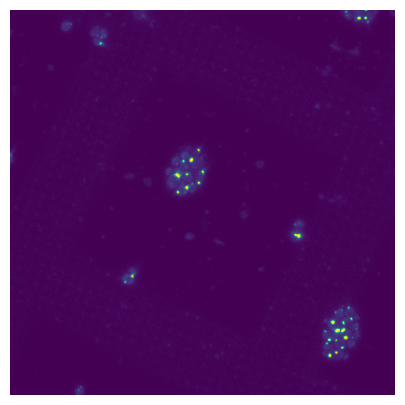

In [ ]:
num = test_stack.shape[0]
fig,ax = plt.subplots(1,num, figsize=(15,5))
for chan in range(num):
    if num == 1:
        ax.imshow(np.max(test_stack[chan],axis=0))
        ax.axis('off')
    else:
        ax[chan].imshow(np.max(test_stack[chan],axis=0))
        ax[chan].axis('off')

In [5]:
# Load image stack for debugging
stack = io.imread('input.tif', plugin="tifffile")

#stack = test_stack[0].astype(np.float16)
logging.debug(stack.shape)
logging.debug(stack.dtype)

(39, 2048, 2048)
uint8


In [17]:
print(np.max(stack))

255


In [6]:
scalexy, scalez = 0.5, 1
if np.max(scalexy) == 1 and np.max(scalez) == 1:
    stack_scaled = stack
else:
    stack_scaled = rescale(stack, (scalez,scalexy,scalexy), mode='constant', order=2, anti_aliasing=True) 
logging.debug(stack_scaled.shape)

: 

In [ ]:
# This is meant to be representative of the arctis 100x widefield image capture (all distance units are in microns)
psf = np.zeros_like(stack_scaled)
psf = tfd_psf.GibsonLanni(
    na=NA,           # Numerical aperture
    m=M,             # Magnification
    ni0=ni0,         # Immersion RI
    res_lateral=res_lateral, # X/Y resolution
    res_axial=res_axial,     # Axial resolution
    wavelength=wavelength,  # Emission wavelength 
    size_x=np.max((size_x, int(stack_scaled.shape[2]))), 
    size_y=np.max((size_y, int(stack_scaled.shape[1]))), 
    size_z=np.min((size_z, int(stack_scaled.shape[0]))),
    ns = ns,
    ng0 = ng0,
    ti0 = ti0,
    tg0 = tg0,
).generate()
logging.debug((psf.shape, psf.dtype))


--- Logging error ---
Traceback (most recent call last):
  File "/home/johann/anaconda3/envs/tf3.10/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/home/johann/anaconda3/envs/tf3.10/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/home/johann/anaconda3/envs/tf3.10/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/home/johann/anaconda3/envs/tf3.10/lib/python3.10/logging/__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/home/johann/anaconda3/envs/tf3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/johann/anaconda3/envs/tf3.10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/johann/anaconda3/envs/tf3.10/lib/python3.10/site-packag

In [20]:
# This is meant to be representative of the Leica SP8 50x widefield image capture (all distance units are in microns)
'''
psf = np.zeros_like(stack_scaled)
psf = tfd_psf.GibsonLanni(
    na          = test_fov.NA,                           # Numerical aperture
    m           = test_fov.mag,                          # Magnification
    ni0         = ni0,                                   # Immersion RI
    res_lateral = test_fov.resolution[test_fov.resolution['dimension_name'] == 'x']['resolution_nm'].values[0]  * 1000, # X/Y resolution
    res_axial   = test_fov.resolution[test_fov.resolution['dimension_name'] == 'z']['resolution_nm'].values[0]  * 1000, # Axial resolution
    wavelength  = test_fov.channels[0]['center_wavelength'],  # Emission wavelength 
    size_x      = np.max((size_x, int(stack_scaled.shape[2]))), 
    size_y      = np.max((size_y, int(stack_scaled.shape[1]))), 
    size_z      = np.min((size_z, int(stack_scaled.shape[0]))),
    ns          = 1,                                     # specimen refractive index (RI)
    ng0         = 1,                                     # Refractive index of coverslip
    ti0         = test_fov.working_distance_mm*1000,     # microns, working distance (immersion medium thickness) design value
    tg0         = 0,                                     # microns, coverslip thickness design value
).generate().astype(np.float16)
logging.debug((psf.shape, psf.dtype))
'''

NameError: name 'test_fov' is not defined

In [ ]:
# In case your GPU setup allows for a continuous oberserver or saving of intermediate steps (requires more memory, and is not used here)
imgs = []
scores = {}
def observer(img, i, *args):
    imgs.append(img)
    scores[i] = {
    'mse': mean_squared_error(stack_scaled, img),
    #'ssim': structural_similarity(stack_scaled, img, data_range=1), #@TODO find out why SSIM doesn't work as expected
    'psnr': peak_signal_noise_ratio(stack_scaled, img)
    }
    
    if i % 5 == 0:
        if i == 5:
            logging.debug('Observing iteration = {} (dtype = {}, max = {:.3f})'.format(i, img.dtype, img.max()))        
        else:            
            #logging.info('Observing iteration = {} (MSE = {:.2f},SSIM = {:.2f}, PSNR = {:.2f})'.format(i, scores[i]['mse'],scores[i]['ssim'],scores[i]['psnr']))        
            logging.debug('Observing iteration = {} (MSE = {:.2f}, PSNR = {:.2f})'.format(i, scores[i]['mse'],scores[i]['psnr']))        


acq = tfd_data.Acquisition(stack_scaled,psf)
logging.debug(acq.shape())

{'data': (39, 2048, 2048), 'kernel': (39, 2048, 2048), 'actual': None}
{'data': (39, 2048, 2048), 'kernel': (39, 2048, 2048), 'actual': None}
{'data': (39, 2048, 2048), 'kernel': (39, 2048, 2048), 'actual': None}


In [ ]:
# Run the deconvolution process and note that deconvolution initialization is best kept separate from 
# execution since the "initialize" operation corresponds to creating a TensorFlow graph, which is a 
# relatively expensive operation and should not be repeated across multiple executions
#algo = fd_restoration.RichardsonLucyDeconvolver(data.ndim, observer_fn=observer).initialize()
#res = algo.run(fd_data.Acquisition(data=data, kernel=psf), niter=30).data
channels = 0
niter = 20
algo = tfd_restoration.RichardsonLucyDeconvolver(n_dims=3,pad_mode='none').initialize()#, observer_fn=observer,
res = algo.run(acq, niter=niter)
logging.debug("Finished successfully!")

2024-04-09 19:29:26.430132: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 19:29:26.431425: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 19:29:26.432019: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 19:29:26.449751: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-09 19:29:26.449808: I tensorflow/core/common_runtime/gpu/gpu

InternalError: Graph execution error:

2 root error(s) found.
  (0) INTERNAL: Failed to create cuFFT batched plan with scratch allocator
	 [[{{node IFFT3D}}]]
	 [[result/_131]]
  (1) INTERNAL: Failed to create cuFFT batched plan with scratch allocator
	 [[{{node IFFT3D}}]]
0 successful operations.
0 derived errors ignored.

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
findfont: score(FontEntry(fname='/home/johann/anaconda3/envs/tf3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/home/johann/anaconda3/envs/tf3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/home/johann/anaconda3/envs/tf3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/home/johann/anaconda3/envs/tf3.10/lib/python3.10/site-packages/matplotlib/mp

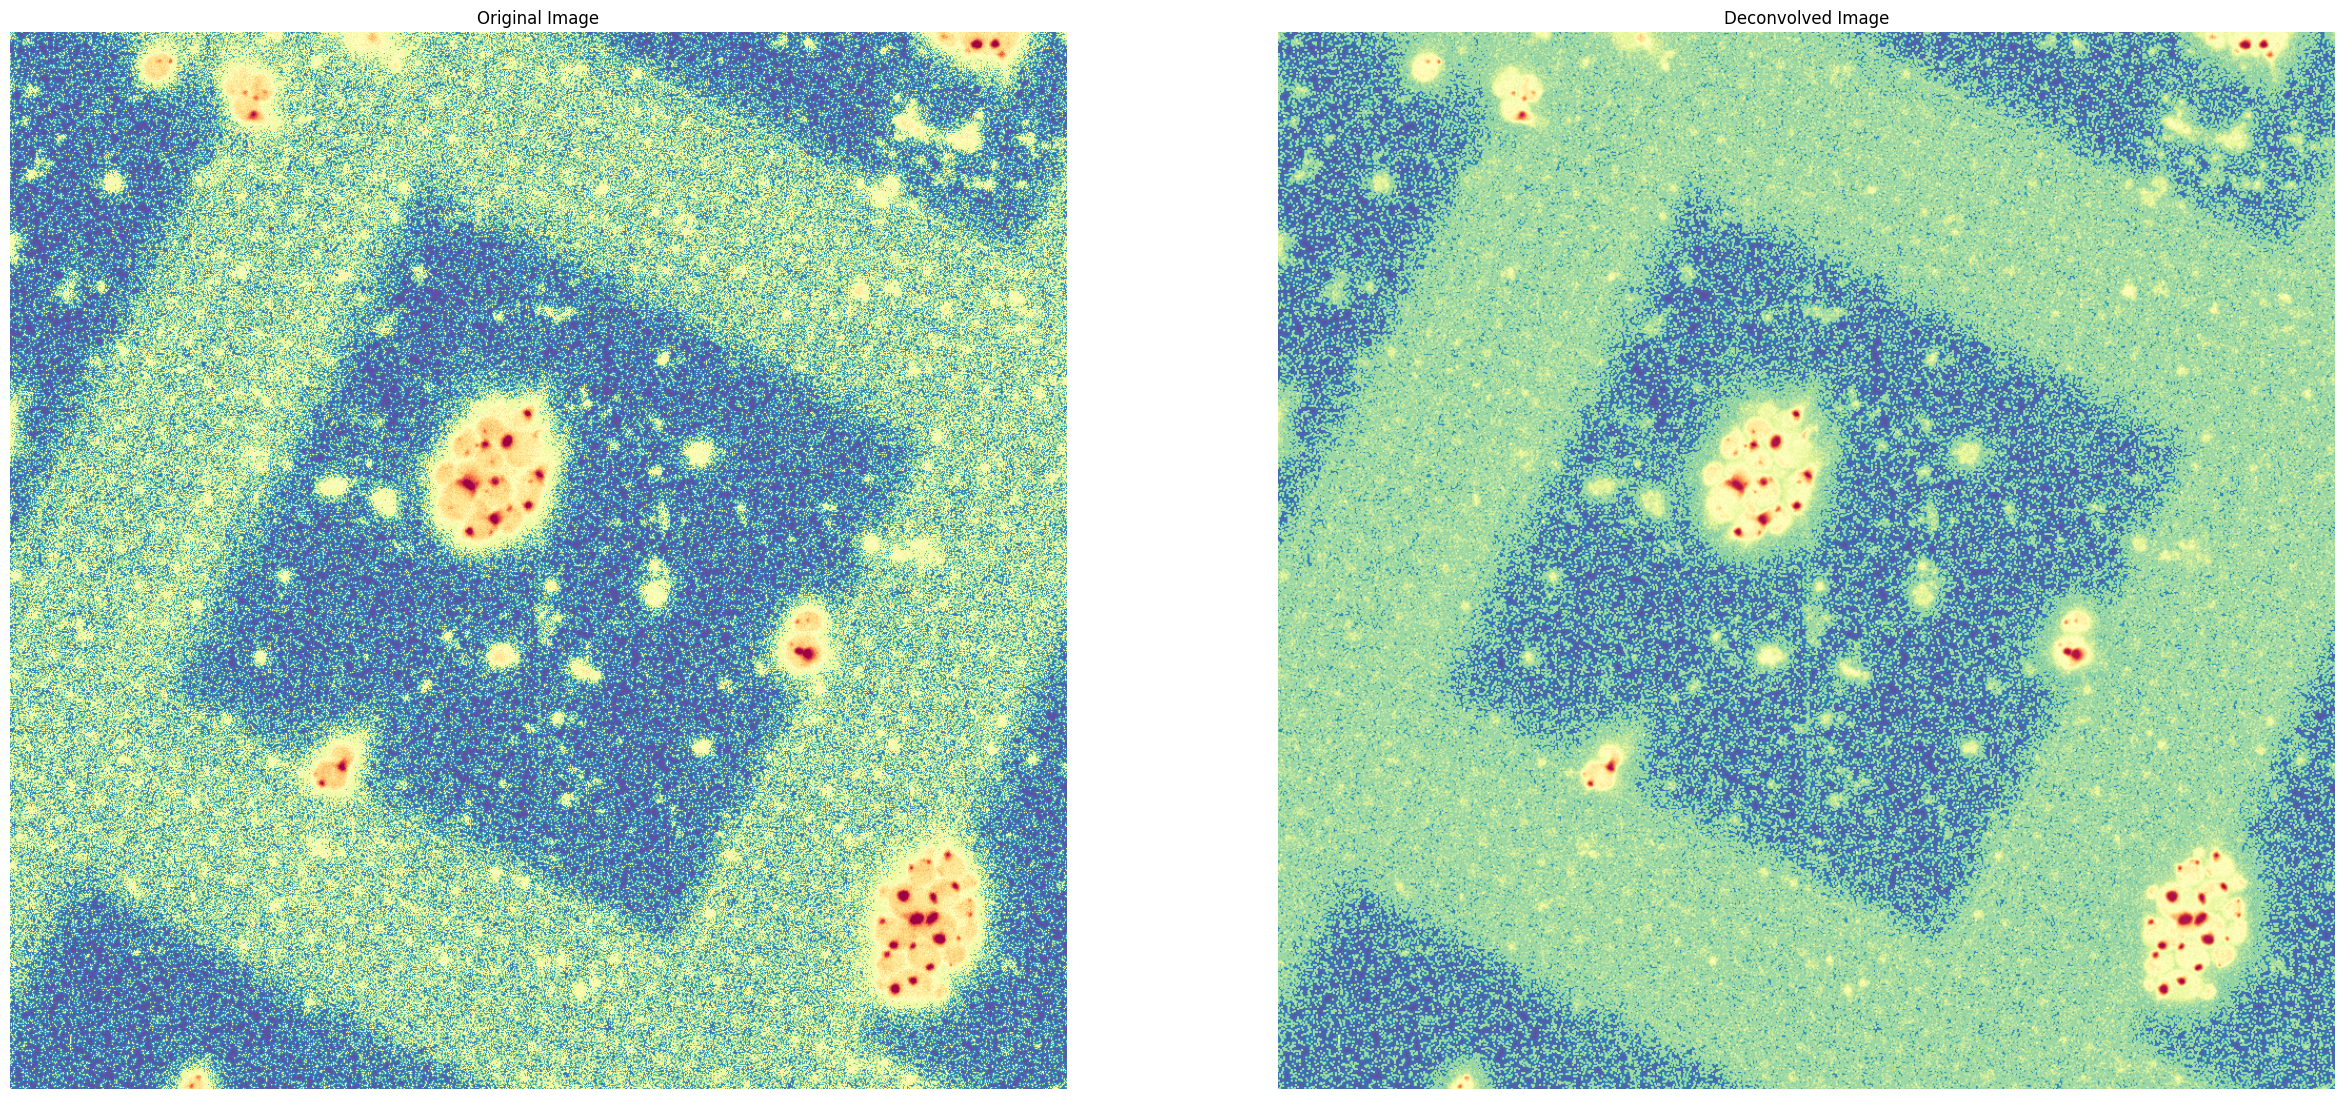

In [ ]:
fig, axs = plt.subplots(1, 2)
axs = axs.ravel()
fig.set_size_inches(30, 15)
center = tuple([slice(None), slice(10, -10), slice(10, -10)])
titles = ['Original Image', 'Deconvolved Image']
for i, d in enumerate([stack_scaled, res.data ]):#res.data
    img = exposure.adjust_gamma(d[center].max(axis=0), gamma=.2)
    axs[i].imshow(img, cmap='Spectral_r')
    axs[i].set_title(titles[i])
    axs[i].axis('off')

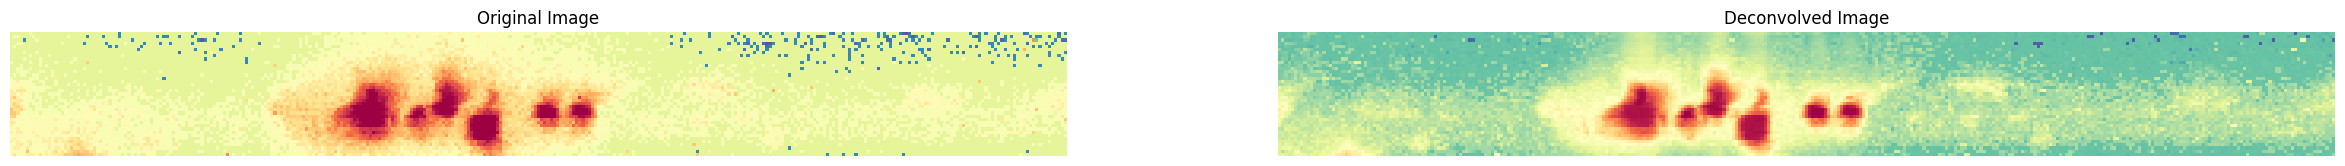

In [ ]:
fig, axs = plt.subplots(1, 2)
axs = axs.ravel()
fig.set_size_inches(30, 30)
xz_projection_data = np.max(stack_scaled, axis=1)
xz_projection_decon = np.max(res.data, axis=1)
titles = ['Original Image', 'Deconvolved Image']
for i, d in enumerate([xz_projection_data[:,333:666], xz_projection_decon[:,333:666] ]):#res.data
    img = exposure.adjust_gamma(d,gamma=.2)
    axs[i].imshow(img, cmap='Spectral_r')
    axs[i].set_title(titles[i])
    axs[i].axis('off')

In [ ]:
# Function to plot a selectable image from the stack

def plot_image(i):
    fig,(ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
    ax1.imshow(exposure.adjust_gamma(stack_scaled[i, slice(10, -10), slice(10, -10)]), cmap='Spectral_r')#)'gray'
    ax2.imshow(exposure.adjust_gamma(res.data[i, slice(10, -10), slice(10, -10)]), cmap='Spectral_r')#'Spectral_r')'gray'
    ax2.axis('off')
    fig.show()

# Create a slider widget
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=res.data.shape[0] - 1,
    step=1,
    description='Image Index:',
    continuous_update=True
)

widgets.interactive(plot_image, i=slider) # Create an interactive widget

interactive(children=(IntSlider(value=0, description='Image Index:', max=38), Output()), _dom_classes=('widget…

handle_msg[d631fb0a2093483596aaaf6d95bddd6d]({'header': {'date': datetime.datetime(2024, 4, 5, 12, 41, 7, 756000, tzinfo=tzutc()), 'msg_id': '6d1eeb2c-fe08-4f17-ab93-d2383243a1af', 'msg_type': 'comm_msg', 'session': 'a465bb1c-feb0-47c5-92d2-1f1c5f5ac427', 'username': '98a1888f-f852-4509-87ec-d75e777be33c', 'version': '5.2'}, 'msg_id': '6d1eeb2c-fe08-4f17-ab93-d2383243a1af', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': 'd631fb0a2093483596aaaf6d95bddd6d', 'data': {'method': 'update', 'state': {'outputs': [{'name': 'stderr', 'text': '/tmp/ipykernel_386/548820959.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown\n  fig.show()\n', 'output_type': 'stream'}, {'output_type': 'display_data', 'data': {'text/plain': '<Figure size 2000x1000 with 2 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAABk4AAALxCAYAAAAaHFrXAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/H5lhTAAAACXBIWXMAAA9hAAAPYQGoP6d

In [ ]:
#io.imsave(output_folder + 'deconv.tif',res.data)
#io.imsave(output_folder + 'input.tif',stack_scaled)